# iSpeculator emulator MCMC sanity check
In this notebook I will sanity check the MCMC pipeline of `iSpeculator` emulator model. 

1. Get $\theta_{\rm median}$ from MCMC run
2. Generate toy data: model($\theta_{\rm median}$)
3. Run MCMC on toy data
4. Compare posterior to $\theta_{\rm median}$. 

**08/20/2020 update**: Default prior for the SFH basis coefficients is no longer a Dirichlet distribution

In [1]:
import os 
import h5py 
import numpy as np 
import corner as DFM 
# --- gqp_mc ---
from gqp_mc import util as UT 
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# local directory where the MCMC files are stored
dir_mcmc = '/Users/ChangHoon/data/gqp_mc/mini_mocha/ispeculator/'

In [4]:
f = h5py.File(os.path.join(dir_mcmc, 'lgal.specphoto.noise_bgs0_legacy.emulator.4.postproc.hdf5'), 'r')
mcmc = {} 
for k in f.keys(): 
    mcmc[k] = f[k][...]

In [5]:
mcmc.keys()

dict_keys(['flux_photo_data', 'flux_photo_ivar_data', 'flux_photo_model', 'flux_spec_data', 'flux_spec_ivar_data', 'flux_spec_model', 'mcmc_chain', 'model', 'prior_range', 'redshift', 'theta_1sig_minus', 'theta_1sig_plus', 'theta_2sig_minus', 'theta_2sig_plus', 'theta_med', 'theta_names', 'wavelength_data', 'wavelength_model'])

In [6]:
print(mcmc['redshift'])

0.2102643


In [7]:
theta_in = mcmc['theta_med']
for name, tt_in in zip(mcmc['theta_names'], theta_in): 
    print('%s = %.1f' % (name, tt_in))

b'logmstar' = 10.2
b'beta1_sfh' = 0.3
b'beta2_sfh' = 0.5
b'beta3_sfh' = 0.0
b'beta4_sfh' = 0.2
b'gamma1_zh' = 0.0
b'gamma2_zh' = 0.0
b'tau' = 0.3
b'f_fiber' = 0.4
b'logsfr.100myr' = -0.4
b'logsfr.1gyr' = -0.3
b'logz.mw' = -2.9


(0.0, 25.0)

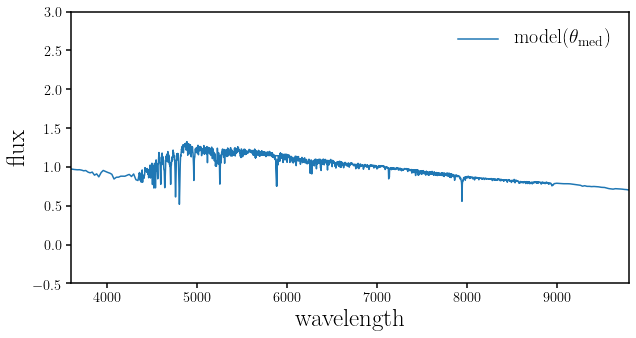

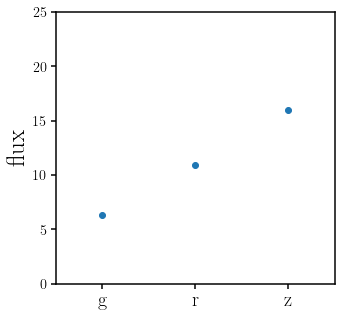

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(mcmc['wavelength_model'], mcmc['flux_spec_model'], 
         c='C0', label=r'model($\theta_{\rm med}$)')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3.6e3, 9800)
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim(-0.5, 3)
sub.legend(loc='upper right', fontsize=20)

fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(range(len(mcmc['flux_photo_model'])), mcmc['flux_photo_model'], color='C0')
sub.set_xticks([0, 1, 2])
sub.set_xticklabels(['g', 'r', 'z'], fontsize=20)
sub.set_xlim(-0.5, 2.5)
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim(0., 25)

In [9]:
ifitter = Fitters.iSpeculator(model_name='emulator') 
#ifitter_fsps = Fitters.iSpeculator(model_name='fsps')

In [10]:
prior = ifitter._default_prior(f_fiber_prior=[theta_in[8]-0.1, theta_in[8]+0.1])
prior.min[1:5] = 0.
prior.max[1:5] = 1.

In [11]:
# initiating fit
mcmc_sanity = ifitter.MCMC_spectrophoto(
    mcmc['wavelength_model'], 
    mcmc['flux_spec_model'],
    np.ones(len(mcmc['wavelength_model'])), 
    mcmc['flux_photo_model'], 
    np.ones(len(mcmc['flux_photo_model'])), 
    mcmc['redshift'], 
    mask='emline', 
    prior=prior, 
    dirichlet_transform=False, 
    nwalkers=40,  
    burnin=200, 
    niter='adaptive', 
    maxiter=50000, 
    silent=False)

getting initial theta


/Users/ChangHoon/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/Users/ChangHoon/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1520: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  integrand = integrand[values_slice]


initial theta = [10.391201702855888, 0.5368660650974664, 0.50838019217045, 0.43458986779684716, 0.5032504801686679, 0.003719648808543634, 0.0036777459006187632, 1.472294065637426, 0.3862270784016879]
running burn-in
running main chain
chain #1
chain #2
chain #3
chain #4
chain #5
chain #6
chain #7
chain #8
chain #9
chain #10
chain #11
chain #12
chain #13
chain #14
chain #15
chain #16
chain #17
converged!


In [12]:
for i in range(9): 
    print('%s : %f , %f' % (mcmc_sanity['theta_names'][i], theta_in[i], np.median(ifitter._flatten_chain(mcmc_sanity['mcmc_chain']), axis=0)[i]))

b'logmstar' : 10.223117 , 10.246390
b'beta1_sfh' : 0.320172 , 0.225880
b'beta2_sfh' : 0.493828 , 0.516246
b'beta3_sfh' : 0.002942 , 0.016371
b'beta4_sfh' : 0.158544 , 0.533927
b'gamma1_zh' : 0.000791 , 0.000644
b'gamma2_zh' : 0.000217 , 0.000308
b'tau' : 0.307739 , 0.381746
b'f_fiber' : 0.367822 , 0.372980


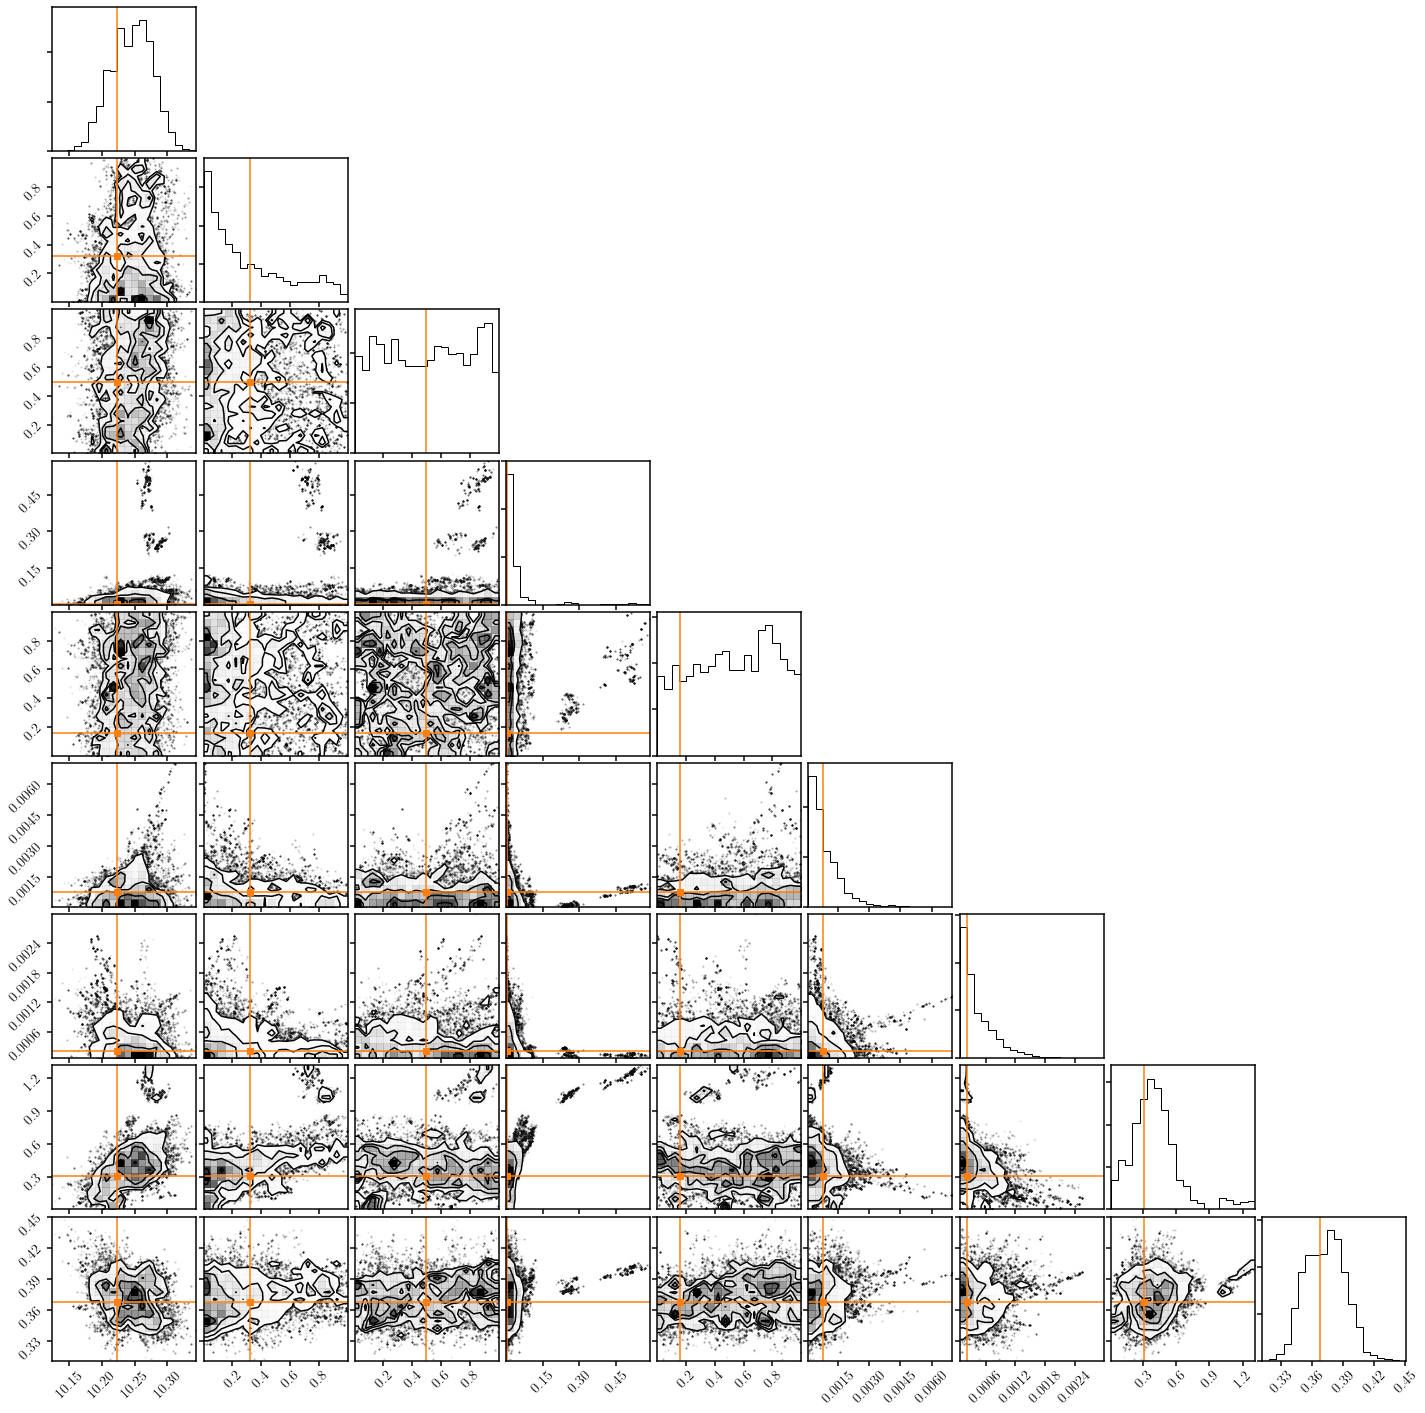

In [13]:
_ = DFM.corner(ifitter._flatten_chain(mcmc_sanity['mcmc_chain']), truths=theta_in[:9], truth_color='C1')

(0.0, 25.0)

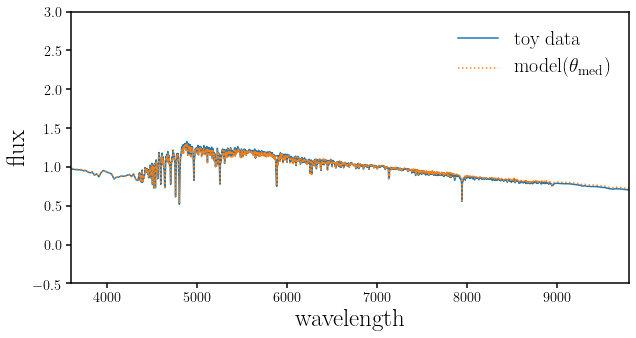

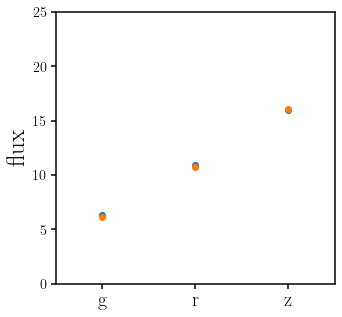

In [15]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(mcmc['wavelength_model'], mcmc['flux_spec_model'], 
         c='C0', label=r'toy data')

sub.plot(mcmc_sanity['wavelength_model'], mcmc_sanity['flux_spec_model'], 
         c='C1', ls=':', label=r'model($\theta_{\rm med}$)')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3.6e3, 9800)
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim(-0.5, 3)
sub.legend(loc='upper right', fontsize=20)

fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(range(len(mcmc['flux_photo_model'])), mcmc['flux_photo_model'], color='C0')
sub.scatter(range(len(mcmc['flux_photo_model'])), mcmc_sanity['flux_photo_model'], color='C1')
sub.set_xticks([0, 1, 2])
sub.set_xticklabels(['g', 'r', 'z'], fontsize=20)
sub.set_xlim(-0.5, 2.5)
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim(0., 25)

The posteriors from MCMC does not precisely match the input paramter values. Given that this is a no noise case, they should... This may again be due to the SFH prior imposed by the Dirichlet prior.

**08/20/2020 updates**
With uniform priors, we're able to more or less recover the input parameter values. Also, ${\rm model}(\theta_{\rm median})$ closely reproduces the data. 